# 参考サイト
- [Diffusionモデル実装](https://data-analytics.fun/2022/08/24/diffusion-model-pytorch-1/)
- [U-Net実装](https://data-analytics.fun/2022/08/27/diffusion-model-pytorch-2-unet/)
- [モデル学習](https://data-analytics.fun/2022/09/01/diffusion-model-pytorch-3/)

In [1]:
!pip install numpy
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install pillow

In [2]:
import numpy as np
from tqdm.auto import tqdm
 
# PyTorch, 計算関係
import torch
import torch.nn as nn
 
# 描画用
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 拡散、逆拡散過程の実装 (参考: [Diffusionモデル実装](https://data-analytics.fun/2022/08/24/diffusion-model-pytorch-1/))

## 拡散過程
### sub 関数

In [3]:
# aからt時点のデータをx_shapeの型で取り出す
def extract(a, t, x_shape):
    batch_size = t.shape[0] # バッチサイズ
    out = a.gather(-1, t.cpu()) # aの最後の次元 ⇒ timestepに対応するalphaを取ってくる
    return out.reshape(batch_size, *((1,) * (len(x_shape) -  1))).to(t.device) # バッチサイズ x 1 x 1 x 1にreshape

# timestepからbetaを作成 (0.0001 ~ 0.02まで線形に増加)
def linear_beta_schedule(timesteps):
  beta_start = 0.0001
  beta_end = 0.02
  return torch.linspace(beta_start, beta_end, timesteps)

### 変数定義
拡散過程における時刻tでの画像の様子$x_t$を以下のようなマルコフ過程として定義する。
ここでの$I$は単位行列を表す。
$$
q(x_t) = q(x_0) \prod q(x_t | x_{t-1}) \\
q(x_t | x_{t-1}) = N(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_t I)
$$
これは
$$
q(x_t |x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1 - \bar{\alpha}_t) I) \\
\bar{\alpha}_t = \prod \alpha_s \\
\alpha_t = 1 - \beta_t
$$
とも表すことができる。
以下の拡散過程の作成ではこの式に従って関数を作成する。

In [4]:
# 変数定義
timesteps = 200
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1. - betas
# Π α(prod alpha)を計算
alphas_cumprod = torch.cumprod(alphas, axis=0) # 各timestepまでのalphaの積

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

### ノイズ画像の生成
元の画像（のテンソル）$x_0$からt時点の画像（のテンソル）$x_t$を生成する

ここで、$q(x_t |x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1 - \bar{\alpha}_t) I)$から$x_t$は中央値$\sqrt{\bar{\alpha}_t} x_{0}$から$\sqrt{1 - \bar{\alpha}_t}\epsilon_t$ずれていると考えることで
$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon_t
$$
と表せる。以下の`q_sample`ではこれを利用して`x_t`の生成を行っている

ここで、$\epsilon_t$は$x_t$が中央値から$k\sigma$離れているとき$|\epsilon_t| = k$を満たすあるノイズである。

In [5]:
def q_sample(x_start, t, noise=None):
  """
  キレイな画像からノイズを加えた画像をサンプリングする.
  """
  if noise is None: # 呼び出し元からノイズが渡されていなければここでで生成する.
    noise = torch.randn_like(x_start) # 正規乱数
 
  # t時点の平均計算用
  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape) 
  # t時点の標準偏差計算用
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x_start.shape
  )
 
  # (5)式で計算
  return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### transformerの用意
- テスト用の画像
- 画像　<-> テンソル の変換を行うtransformer

を用意する

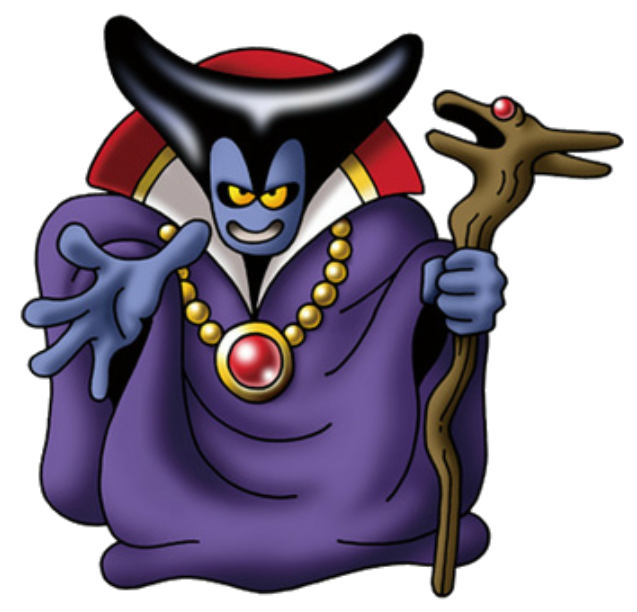

In [6]:
data = 'test_image/image.png'
image = Image.open(data)
image

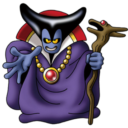

In [ ]:
# 画像のテンソル変換
image_size = 128
transform = Compose([
    Resize(image_size), # サイズを小さくする
    CenterCrop(image_size), # 128 x 170なので中心を取って128 x 128にする
    ToTensor(), # テンソルに変換. これだけだと各要素が[0, 1]の区間の値になっている
    Lambda(lambda t: (t * 2) - 1) # [-1, 1]の区間をとるようにに変換
])
x_start = transform(image).unsqueeze(0) # 0次元にバッチ用の次元を追加

# ノイズ処理後の画像描画のために テンソル -> 画像のtransformerを用意
reverse_transform = Compose([
    Lambda(lambda t: (t + 1) / 2), # 区間[-1, 1]のテンソルを区間[0, 1]のテンソルに変換
    Lambda(lambda t: t.permute(1, 2, 0)), # C × H × W ⇒ H × W × Cに変形
    Lambda(lambda t: t * 255.), # 区間[0, 1]のテンソル ⇒ 区間[0, 255]のテンソルに変換
    Lambda(lambda t: t.numpy().astype(np.uint8)), # 整数に変換
    ToPILImage(), # PILの画像に変換
])
reverse_transform(x_start.squeeze())

In [ ]:
# 元画像のテンソル x_start -> t時点のノイズ画像を生成
def get_noisy_image(x_start, t):
  x_noisy = q_sample(x_start, t) # 元画像からt時点のノイズ画像のテンソルを生成
  noisy_image = reverse_transform(x_noisy.squeeze())
 
  return noisy_image

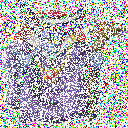

In [ ]:
# テスト t=20時点のノイズ画像を生成
t = torch.tensor([19])
noisy_image = get_noisy_image(x_start, t)
noisy_image

## 逆拡散過程

逆拡散過程は
$$
p_\theta(x_{0:t}) = p_\theta \prod p_\theta(x_{t-1} | x_t) \\
p_\theta(x_{t-1} | x_t) = N(x_{t-1}; \mu_\theta(x_t, t), \sum_\theta(x_t, t))
$$
と表せる。$\theta$はニューラルネットワークのパラメータで
diffusion modelの目的は
- 平均$\mu_\theta(x_t, t)$
- 分散$\sum_\theta(x_t, t)$

を学習することである
> 参考としたページでは2020年に公開された[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)を参考にして制作している。この論文で公開されたDDPMでは$\sum_\theta$を固定しており参考ページもこれに従っているため、ここでも固定して考えている

> なおその後の論文では、タイムステップtを減らしても学習をうまくいくようにするためには$\sum_\theta$も学習した方がよいという結果が出ているらしい

この時$\mu_\theta$は
$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)) 
$$

と表される。

そのため、$\epsilon_\theta(x_t, t)$を学習すればよい。これを単純化していくと損失関数$L_{\text{simple}}(\theta)$は
$$
L_{\text{simple}}(\theta) = \mathbb{E}_{t, x_0, \epsilon}[||\epsilon - \epsilon_\theta(x_t, t)||^2] \\
\therefore L_{\text{simple}}(\theta)= \mathbb{E}_{t, x_0, \epsilon}[||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon_t, t)||^2]
$$
と表せる

### 損失関数

In [10]:
def p_losses(denoise_model, x_start, t, noise=None):
  if noise is None:
    noise = torch.randn_like(x_start)
 
  x_noisy = q_sample(x_start=x_start, t=t, noise=noise) # x_tを計算
  predicted_noise = denoise_model(x_noisy, t) # モデルでノイズを予測

# pytorch.nn.functional.l2_lossだったが、ないので平均二乗誤差を求めるpytorch.nn.MSELossで代用
  MSE = nn.MSELoss()
  loss = MSE(predicted_noise, noise) # 損失を計算
   
  return loss

### 画像生成
[上記の論文](https://arxiv.org/abs/2006.11239)では分散$\sum_\theta(x_t, t) = \sigma_t^2 I$と定義しており
$$
\sigma_t^2 = \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha} _t}\beta_t
$$
である

したがって$p_\theta(x_{t-1} | x_t) = N(x_{t-1}; \mu_\theta(x_t, t), \sum_\theta(x_t, t))$より
$$
x_{t-1} = \mu_\theta(x_t, t) + \sigma_t z
$$
と表せる（[ノイズ画像を生成](#ノイズ画像の生成)で使用した変換と同じ考え方である）

In [11]:
# \bar{\alpha}_t は計算済みのため\bar{\alpha}_{t-1}を計算
alphas_cumprod_prev = nn.functional.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# \sigma_t^2 を計算
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# 1 / \sqrt{\alpha_t}を計算
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # 標準偏差

### 逆拡散による前画像の予測
$x_t \rightarrow x_{t-1}$ を予測する

modelは学習済みの$\epsilon_\theta$を指している

In [12]:
# t はバッチ処理用に時点tの配列、t_indexは時点tのスカラー
@torch.no_grad()
def p_sample(model, x, t, t_index):
  # beta_t
  betas_t = extract(betas, t, x.shape)
  # 1 - √\bar{α}_t
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )
  # 1 / √α_t
  sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
 
  # μ_Θをモデルで求める: model(x, t)
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
  )
 
  if t_index == 0:
    return model_mean
  else:
    posterior_variance_t = extract(posterior_variance, t, x.shape) # σ^2_tを計算
    noise = torch.randn_like(x) # 正規乱数zをサンプリング
 
  return model_mean + torch.sqrt(posterior_variance_t) * noise # x_{t-1}

p_sample をループさせて元画像$x_0$まで予測する

In [13]:
@torch.no_grad()
def p_sample_loop(model, shape):
  device = next(model.parameters()).device
 
  b = shape[0]
  img = torch.randn(shape, device=device)
  imgs = []
 
  for i in tqdm(reversed(range(0, timesteps)), total=timesteps):
    img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
    # img.cupu().numpy()とあるがimg.cpu().numpy()？？
    imgs.append(img.cpu().numpy())
  return imgs

### テスト処理
ただし、モデル$\epsilon_\theta$の学習ができていないためモデルの学習後に行う 

In [14]:
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
  return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

# U-Netによるεの学習 (参考: [モデル学習](https://data-analytics.fun/2022/09/01/diffusion-model-pytorch-3/))

DiffusionモデルではU-Netを改良したものを採用している
> U-Netとはダウンサンプルを行った後アップサンプルを行うようなネットワークである。
> ダウンサンプルではサイズを小さくし、圧縮を行い、チャネル数を増加させており、アップサンプルは逆の操作である
> また、ダウンサンプルの隠れ層の値はアップサンプルの隠れ層の値に結合することで情報の伝播を行っている

U-Netの参考図 (以降の参考図はいずれも[U-Net実装](https://data-analytics.fun/2022/08/27/diffusion-model-pytorch-2-unet/)より引用したものである)
![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-31.png)

U-Netと比較した際の[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)で提案されているモデルの改良点として以下の4点が挙げられている
- 時点情報の埋め込み表現(Position embeddings)の導入
- Wide ResNetの利用（今回は簡単のために通常のResNetを採用している）
- Attentionの導入
- バッチ正規化ではなくグループ正規化の導入

学習の対象となる$\epsilon_\theta(x_t, t)$は$\theta$を定数のパラメータとしているものの$x_t, t$に依存することから、モデルがどの時点かを知る必要がある。これの解決策としてTransformerで提案されているように時点情報の埋め込みが用いられている。

![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-47.png)

In [15]:
!pip install math
!pip install inspect
!pip install functools
!pip install einops
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math
ERROR: Could not find a version that satisfies the requirement inspect (from versions: none)
ERROR: No matching distribution found for inspect
  Using cached functools-0.5.tar.gz (4.9 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for functools (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error: command 'gcc' failed: No such file or directory
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
Failed to build functools
error: failed-wheel-build-for-install

× Failed to build installable wheels for some pyproject.toml based projects
╰─> functools


In [16]:
import math # positional embeddingsのsin, cos用
from inspect import isfunction # inspectモジュール
from functools import partial # 関数の引数を一部設定できる便利ツール
 
# PyTorch, 計算関係
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt

## 補助関数

In [17]:
def exists(x):
  return x is not None

def default(val, d):
  """
  valがNoneでなければTrueを返す.
  Noneの場合, dが関数であれば関数を呼び出した結果を返し, 関数でなければその値を返す.
  """
  if exists(val):
    return val
  return d() if isfunction(d) else d


## 時点情報の埋め込み

前述したように今回作成するdiffusionモデルでは時刻の埋め込み情報を入力として与えることにより時点情報を与えている。

この手法の利点として、時刻tによらず同じネットワークを用いてノイズ$\epsilon_t$の予測を行うことが可能となることが挙げられる。

この時、時点情報の埋め込みにはtransformerで提案されたPosition Embeddingsを利用する。これは以下の式により表される。
$$
PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}}) \\
PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}}) 
$$

したがって、今回は以下のようなクラスを作成した

In [18]:
class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
 
  def forward(self, time):
    device = time.device 
    # 10000^{2i / d_{model}}
    half_dim = self.dim // 2 # 次元の半分
    embeddings = math.log(10000) / (half_dim - 1) 
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

    # pos / 10000^{2i / d_{model}}
    embeddings = time[:, None] * embeddings[None, :]
    # sin, cosを結合
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

表示して確認を行う

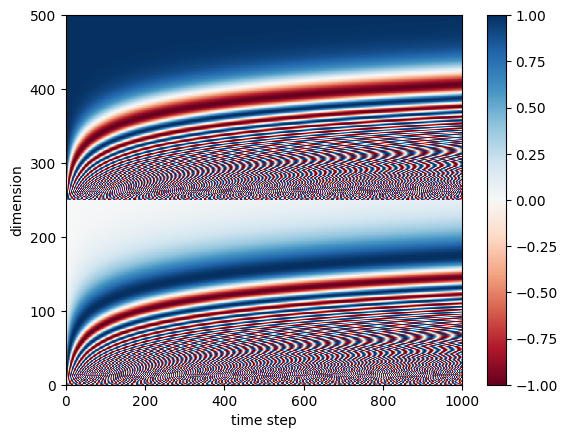

In [19]:
timesteps = 1000
time = torch.arange(timesteps)
pos_emb = SinusoidalPositionEmbeddings(dim=500)
emb = pos_emb(time=time)
plt.pcolormesh(emb.T, cmap='RdBu')
plt.ylabel('dimension')
plt.xlabel('time step')
plt.colorbar()
plt.show()

時点、次元によって[-1, 1]のある程度異なる値が設定されているため、次点の埋め込み表現として機能している

## 残差結合

### 補助クラス

残差結合$f(x) + x$を計算する`forward`メソッドを持った補助クラスを定義する

In [20]:
class Residual(nn.Module):
  """
  残差結合
  """
  def __init__(self, fn):
    super().__init__()
    self.fn = fn
 
  def forward(self, x, *args, **kwargs):
    """
    f(x) + x
    """
    return self.fn(x, *args, **kwargs) + x

アップサンプル、ダウンサンプルの畳み込み層も定義する

- アップサンプルでは転置畳み込み処理
- ダウンサンプルでは通常の畳み込み処理を行う

また、どちらもカーネルサイズ4, ストライド2, パディング1であり、デフォルトでは0パディングが行われる

In [21]:
# アップサンプル
class UpsampleConv(nn.Module):
  """
  upsample用Transposed Convolution
  """
  def __init__(self, dim):
    super().__init__()
    self.trans_conv = nn.ConvTranspose2d(
      in_channels=dim, 
      out_channels=dim, 
      kernel_size=4, 
      stride=2, 
      padding=1 
    )
 
  def forward(self, x):
    return self.trans_conv(x)
  
# ダウンサンプル
class DownsampleConv(nn.Module):
  """
  Downsample用Convolution
  """
  def __init__(self, dim):
    super().__init__()
    self.conv = nn.Conv2d(
      in_channels=dim, 
      out_channels=dim, 
      kernel_size=4, 
      stride=2, 
      padding=1
    )
 
  def forward(self, x):
    return self.conv(x)

### 残差結合ブロック

残差結合ブロックは

畳み込み -> 正規化 -> 活性化関数

の一連の処理を行う畳み込みブロックに残差結合を導入することにより作成される

![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-33.png)

畳み込みブロックは以下のようにして作成される

ここでは活性化関数にSiLU $ (= x \times \sigma(x))$を採用している

In [22]:
class ConvBlock(nn.Module):
  def __init__(self, dim, dim_out, groups=8):
    super().__init__()
    self.proj = nn.Conv2d(dim, dim_out, 3, padding=1) # conv
    self.norm = nn.GroupNorm(groups, dim_out) # normalization
    self.act = nn.SiLU() # activation
 
  def forward(self, x):
    x = self.proj(x) # conv
    x = self.norm(x) # normalization
    x = self.act(x) # activation
    return x

次に残差結合ブロックを作成する

これでは上記参考図のように
- 2度の畳み込みを行いその中間層にtime embeddingの付加 (embeddingのサイズに合わせるため？)
- 残差を畳み込みによりサイズを出力サイズに調整して付加

を行っている

In [23]:
class ResnetBlock(nn.Module):
  def __init__(self, dim, dim_out, time_emb_dim = None, groups=8):
    super().__init__()
    # 時点情報(time_emb)
    if exists(time_emb_dim):
      self.mlp = (
          nn.Sequential(
          nn.SiLU(), 
          nn.Linear(time_emb_dim, dim_out)
          )
      )
    else:
      self.mlp = (None)
      
    # 画像(x)の処理
    self.block1 = ConvBlock(dim, dim_out, groups=groups)
    self.block2 = ConvBlock(dim_out, dim_out, groups=groups)
    if dim != dim_out: # インプットとアウトプットのサイズが違えばconv
      self.res_conv = nn.Conv2d(dim, dim_out, 1)
    else:
       self.res_conv = nn.Identity()
 
  def forward(self, x, time_emb=None):
    # conv1
    h = self.block1(x) 
     
    # time embの付加
    if exists(self.mlp) and exists(time_emb):
      time_emb = self.mlp(time_emb)
      # 「バッチサイズ × チャネル数」の2次元の時点の埋め込み情報を「バッチサイズ × チャネル数 × 1 × 1」の4次元に変換
      h = rearrange(time_emb, "b c -> b c 1 1") + h 
 
    # conv 2
    h = self.block2(h)
     
    # conv + 残差結合
    return h + self.res_conv(x)

## atention

今回の手法では、ダウンサンプル、アップサンプルの際はlinear attention, 中間ブロックの畳み込みは通常のdot-product attentionを採用している

### dot-product attention

dot-product attentionはクエリQ, キーKを使って表されるウェイトをバリューVにかけることで行われる
$$
Attention\_Weight = softmax(\frac{QK^T}{\sqrt{d_{model}}}) \\
output = Attention\_Weight \cdot V
$$

また、通常はヘッドを複数に分けたmulti-head attentionが利用される。
この手法ではQ, K, Vをヘッドの数に分割しoutputを計算したのち結合することで行われる

（実際にTransformerの論文でもmulti-head attentionが利用されている）

In [ ]:
class Attention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head ** (- 0.5) # 1 / d_{model} = d^(-1/2) 
    self.heads = heads
    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
    self.to_out = nn.Conv2d(hidden_dim, dim, 1)
 
  # (batch, dim, height, width)の順なことに注意
  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1) # Q, K, Vの3つにわける (c × h × w -> (dim × heads) × h × w) (batch数を3にして分ける？？)
    # (dim × heads) × h × w -> heads × dim × (h × w)（bはバッチ数）
    # これによりヘッド数で分割
    q, k, v = map(
        lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )
    # q / d_{model}
    q = q * self.scale
 
    # (Q K^T) / d_{model}
    sim = einsum("b h d i, b h d j -> b h i j", q, k)
    # softmaxを取る際に計算を安定させるために最大値を引く
    sim = sim - sim.amax(dim=-1, keepdim=True).detach()
    # softmaxを計算
    attn = sim.softmax(dim=-1)

    # attention_weight × V
    out = einsum("b h i j, b h d j -> b h i d", attn ,v)

    # ヘッド数で分割するために変形を行ったためその影響を取り除く
    out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
    return self.to_out(out)

### linear attention

dot-product attentionでは$QK^T$の計算を行うがこれは計算量が画像のサイズ$(h \times w)^2$に比例して大きくなる

実際に今回以下のコードでは $heads \times dim \times (h \times w) \times (h \times w)$ の行列を出力しているため$O((h \times w)^2)$の計算量を持つ
```python
sim = einsum("b h d i, b h d j -> b h i j", q, k)
```

これを改善するためにlinear attention では $(QK^T)V \rightarrow Q(K^TV)$ と変更して計算することで$O(n^2) \rightarrow O(dim \times dim)$に変更する

In [ ]:
class LinearAttention(nn.Module):
  def __init__(self, dim, heads=4, dim_head=32):
    super().__init__()
    self.scale = dim_head ** (- 0.5) # 1 / d_{model} = d^(-1/2)
    self.heads = heads
    hidden_dim = dim_head * heads
    self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
    self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                nn.GroupNorm(1, dim))
     
  def forward(self, x):
    # dot-productと同じ
    b, c, h, w = x.shape
    qkv = self.to_qkv(x).chunk(3, dim=1)
    q, k, v = map(
        lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
    )
 
    # softmaxを計算
    q = q.softmax(dim=-2)
    k = k.softmax(dim=-1)

    # (Q K^T) / d_{model}
    q = q * self.scale
    # K^T V
    context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

    # Q (K^T V)
    out = torch.einsum("b h d e, b h d n -> b h e n", context, q)

    # ヘッド数で分割するために変形を行ったためその影響を取り除く
    out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
    return self.to_out(out)

## グループ正規化

![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-35.png)

- バッチ正規化

各チャネル内のデータ（画像サイズ$h \times w$ $\times$ バッチ数N）に対して平均・標準偏差で正規化

- グループ正規化

1つのバッチ内のチャネルグループに対して平均・標準偏差で正規化

In [26]:
# preNorm.forward()でグループ正規化を行ったデータにfnを適用
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.fn = fn
    # pytorch.nn.GroupNormを用いてグループ正規化 (num_groupsはnum_channelsの約数である必要がある)
    self.norm = nn.GroupNorm(num_groups=1, num_channels=dim)
 
  def forward(self, x):
    x = self.norm(x)
    return self.fn(x)

## U-Netの作成

U-Netは以下図のように畳み込み → ダウンサンプル → 中間ブロック → アップサンプル → 畳み込み、という順で処理をしていく
![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-17.png)

In [27]:
class Unet(nn.Module):
  def __init__(
    self,
    dim,
    init_dim=None,
    out_dim=None,  
    dim_mults=(1, 2, 4, 8),
    channels=3,
    with_time_emb=True,
    resnet_block_groups=8,
  ):
    # 初期化
    super().__init__()
 
    self.channels = channels
    init_dim = default(init_dim, dim // 3 * 2)
    self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)
 
    dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
    in_out = list(zip(dims[:-1], dims[1:])) # (input_dim, output_dim)というタプルのリストを作成する
 
    resnet_block = partial(ResnetBlock, groups=resnet_block_groups)
 
    # time embeddings
    if with_time_emb:
      time_dim = dim
      # time_mlp: pos emb -> Linear -> GELU -> Linear
      self.time_mlp = nn.Sequential(
          SinusoidalPositionEmbeddings(dim),
          nn.Linear(dim, time_dim),
          nn.GELU(),
          nn.Linear(time_dim, time_dim)
      )
    else:
      time_dim = None
      self.time_mlp = None
 
    self.downs = nn.ModuleList([])
    self.ups = nn.ModuleList([])
    num_resolutions = len(in_out) # blockを処理する回数
 
    # ダウンサンプル
    for ind, (dim_in, dim_out) in enumerate(in_out):
      is_last = ind >= (num_resolutions - 1)
 
      self.downs.append(
          nn.ModuleList(
              [
                  resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
                  resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
                  Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                  DownsampleConv(dim_out) if not is_last else nn.Identity(),
                
              ]
          )
      )
 
    # 中間ブロック
    mid_dim = dims[-1]
    self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
    self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
    self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
 
    # アップサンプル
    for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
      is_last = ind >= (num_resolutions - 1)
 
      self.ups.append(
          nn.ModuleList(
              [
                resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
               resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
               Residual(PreNorm(dim_in, LinearAttention(dim_in))),
               UpsampleConv(dim_in) if not is_last else nn.Identity(),
              ]
          )
      )
    out_dim = default(out_dim, channels)
    self.final_conv = nn.Sequential(
        resnet_block(dim, dim),
        nn.Conv2d(dim, out_dim, 1)
    )
 
  def forward(self, x, time):
    x = self.init_conv(x)
    t = self.time_mlp(time) if exists(self.time_mlp) else None
    h = []
 
    # ダウンサンプル
    for block1, block2, attn, downsample in self.downs:
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      h.append(x)
      x = downsample(x)
 
    # 中間
    x = self.mid_block1(x, t)
    x = self.mid_attn(x)
    x = self.mid_block2(x, t)
 
    # アップサンプル
    for block1, block2, attn, upsample in self.ups:
      x = torch.cat((x, h.pop()), dim=1) # downsampleで計算したhをくっつける
      x = block1(x, t)
      x = block2(x, t)
      x = attn(x)
      x = upsample(x)
 
    return self.final_conv(x)

### コードの説明

#### time embedding
![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-26.png)

参考図の一連の処理を`nn.Sequential`を用いて定義している

`SinusoidalPositionEmbeddings`は引数を$d_{model}$時点情報の埋め込み表現をとして計算するクラスである

```python
    # time embeddings
    if with_time_emb:
      time_dim = dim
      # time_mlp: pos emb -> Linear -> GELU -> Linear
      self.time_mlp = nn.Sequential(
          SinusoidalPositionEmbeddings(dim),
          nn.Linear(dim, time_dim),
          nn.GELU(),
          nn.Linear(time_dim, time_dim)
      )
    else:
      time_dim = None
      self.time_mlp = None
```
ここで定義した`self.time_mlp`を`forward`関数の以下の箇所で使用し、指定した時間のtime embedding表現を手に入れている

```python
 t = self.time_mlp(time) if exists(self.time_mlp) else None
 ```


#### ダウンサンプル

![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-23.png)
- x: 出力
- h: アップサンプルの隠れ層に結合する出力

これは以下のコードで定義している

ここでの`in_out`は`(input_dim, output_dim)`の組合せのリストであり、この要素の回数分繰り返すことで`self.downs`に上記の一連の処理のセットを順に格納している

`resnet_block`は本クラスの前半で以下のように定義されている

```python
resnet_block = partial(ResnetBlock, groups=resnet_block_groups)
```

`partial`は引数を事前に一部定義することができる関数であり、残差結合ブロック`ResnetBlock`のグループ正規化の際のグループ数をあらかじめ定義したコンストラクタである

`Residual`は残差結合の項目で定義したクラスであり、`Residual(fn)`で定義した関数`fn`の残差結合を`Residual.forward(x)`で行うことができる

また、`PreNorm`はグループ正規化を実行するクラスであり、`PreNorm(dim, fn)`で定義したdimのチャンネル数の要素を分割しグループ正規化を実行したのちにfnを適用する`PreNorm.forward(x)`メソッドが定義されている

`DownsampleConv`も同様に残差結合の項目で定義したクラスであり、`DownsampleConv(dim)`で定義したdim数でのダウンサンプルを実行する`DownsampleConv.forward(x)`が定義されている

```python
# ダウンサンプル
for ind, (dim_in, dim_out) in enumerate(in_out):
  is_last = ind >= (num_resolutions - 1)
 
  self.downs.append(
      nn.ModuleList(
          [
              resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
              resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
              Residual(PreNorm(dim_out, LinearAttention(dim_out))),
              DownsampleConv(dim_out) if not is_last else nn.Identity(),
          ]
      )
  )
```
また、`DownsampleConv(dim_out) if not is_last else nn.Identity()`とあるように最後のダウンサンプルの処理では畳み込みを行わないこととしている

`forward`メソッド内では以下で利用している

```python
# ダウンサンプル
for block1, block2, attn, downsample in self.downs:
  x = block1(x, t)
  x = block2(x, t)
  x = attn(x)
  h.append(x)
  x = downsample(x)
```


#### 中間ブロック
![alt text](https://data-analytics.fun/wp-content/uploads/2022/08/image-22.png)

以下の箇所で定義を行っている

```python
# 中間ブロック
mid_dim = dims[-1]
self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
```

`forward`メソッドでは以下で利用している

```python
# 中間
x = self.mid_block1(x, t)
x = self.mid_attn(x)
x = self.mid_block2(x, t)
```

#### アップサンプル

以下の箇所で定義している
```python
# アップサンプル
for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
  is_last = ind >= (num_resolutions - 1)
  self.ups.append(
      nn.ModuleList(
          [
           resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
           resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
           Residual(PreNorm(dim_in, LinearAttention(dim_in))),
           UpsampleConv(dim_in) if not is_last else nn.Identity(),
          ]
      )
  )
```

`forward`メソッドでは以下で利用している
```python
# アップサンプル
for block1, block2, attn, upsample in self.ups:
  x = torch.cat((x, h.pop()), dim=1) # downsampleで計算したhをくっつける
  x = block1(x, t)
  x = block2(x, t)
  x = attn(x)
  x = upsample(x)
```

## U-Netの動作確認

パラメータの設定

In [28]:
image_size = 128
channels = 3
batch_size = 8
timesteps = 200

U-Netのモデルのインスタンスの作成

In [29]:
model = Unet(
    dim=image_size,
    dim_mults=(1, 2, 4, 8),
    channels=channels,
    with_time_emb=True,
    resnet_block_groups=2,
)

画像データと時点tの情報の作成

In [30]:
data = torch.randn((batch_size, channels, image_size, image_size))
t = torch.randint(0, timesteps, (batch_size,)).long()

確認

$8 \times 3 \times 128 \times 128$ のデータが帰ってくれば成功

In [31]:
output = model(data, t)
output.size()

torch.Size([8, 3, 128, 128])

# モデルの学習 (参考: [モデル学習](https://data-analytics.fun/2022/09/01/diffusion-model-pytorch-3/))

In [32]:
!pip install datasets
!pip install pathlib

In [33]:
from datasets import load_dataset # hugging faceのdatasetを使う
 
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
 
from torch.optim import Adam
 
from pathlib import Path

## データセットの準備

Fashion MNIST(靴や服などのファッションに関する白黒画像のデータセット)を使用する

In [34]:
dataset = load_dataset("fashion_mnist")

画像のサイズ、チャネル数(白黒なので1)、バッチサイズを設定

> なお、後のtransformerによる画像のテンソル変換の際に`image.convert("L")`をtransformerに適用しているため、カラー画像の場合も白黒画像に変換されている
>
> そのため、カラー画像もチャネル数を変更することなく扱うことが可能である

In [35]:
image_size = 28
channels = 1
batch_size = 128

torchvisionのtransformsを使って画像の前処理を行う

まず前処理を行うためのtransformerを用意する。
このtransformerでは
- `RandomHorizontalFlip()`でランダムに左右を反転させデータを増加
- `ToTensor`で画像データをテンソルに変換
- `transforms.Lambda`で[0, 1]の閉区間の範囲の値を[-1, 1]の範囲に変換

を行う

In [36]:
transform = Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

次にこのtransformerを用いてテンソルへ変換し、`pixel_values`というキーに格納した辞書型変数を作成する

In [37]:
def transforms_data(examples):
  # 画像データを数値データに変換
  examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
  del examples["image"]
  return examples
 
transformed_dataset = dataset.with_transform(transforms_data).remove_columns("label")
 
# データローダーの作成
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

画像の保存先を設定

In [38]:
results_folder = Path("output/results")
results_folder.mkdir(exist_ok=True)

## モデルの生成

U-Netモデルのインスタンスを作成する

- dim_mults: ダウンサンプル時にチャネルのサイズを何倍にしていくかを表す
- optimizer: Adamを指定

> GPUが使用可能な場合は以下のコードでCUDAを使用するように設定されている
> ```python
> device = "cuda" if torch.cuda.is_available() else "cpu"
> ```

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    resnet_block_groups=4,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

## モデルの学習

まずエポック（学習の回数）を設定

In [40]:
epochs = 5

以下のコードで学習を行う（30分程度要した）
> 時間がかかりすぎる場合などはエポックの変更を検討

損失の計算の際に時点情報をバッチごとにランダムに与えて計算を行っている

```python
    t = torch.randint(0, timesteps, (batch_size,), device=device).long() # タイムステップ情報をバッチごとにランダムに与える
    loss = p_losses(model, batch, t) # 画像を生成し損失を計算
```
これは損失関数が以下のように$t, x_0, \epsilon$についての期待値であるため、バッチ数が十分に多い場合、損失関数がtをランダムに与えた各バッチの$||\epsilon - \epsilon_\theta(x_t, t)||^2$の平均に一致するためである。

$$
L_{simple}(\theta) = \mathbb{E}_{t, x_0, \epsilon}(||\epsilon - \epsilon_\theta(x_t, t)||^2)
$$

In [41]:
for epoch in range(epochs):
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()
 
    batch_size = batch["pixel_values"].shape[0]
    batch = batch["pixel_values"].to(device) # データを設定
 
    t = torch.randint(0, timesteps, (batch_size,), device=device).long() # タイムステップ情報をバッチごとにランダムに与える
    loss = p_losses(model, batch, t) # 画像を生成し損失を計算
 
    if step % 10 == 0: # 表示
        print(f"Loss {step:>3}: ",loss.item())
 
    loss.backward() # 勾配の計算
    optimizer.step() # パラメータの更新
 
  # 画像の生成、保存
  samples = sample(model, image_size=image_size, batch_size=25, channels=channels)
  save_image(torch.from_numpy(samples[-1]), str(results_folder / f'sample-{epoch}.png'), nrow=5)

Loss   0:  1.1460187435150146
Loss  10:  0.9503471255302429
Loss  20:  0.8009900450706482
Loss  30:  0.569050669670105
Loss  40:  0.44230589270591736
Loss  50:  0.35988491773605347
Loss  60:  0.30714738368988037
Loss  70:  0.2551831901073456
Loss  80:  0.2600969672203064
Loss  90:  0.20623652637004852
Loss 100:  0.20717297494411469
Loss 110:  0.21283002197742462
Loss 120:  0.18378524482250214
Loss 130:  0.18260760605335236
Loss 140:  0.1658405214548111
Loss 150:  0.1473371684551239
Loss 160:  0.13830997049808502
Loss 170:  0.16791681945323944
Loss 180:  0.15729527175426483
Loss 190:  0.13099879026412964
Loss 200:  0.15932662785053253
Loss 210:  0.1320037692785263
Loss 220:  0.15394076704978943
Loss 230:  0.13214965164661407
Loss 240:  0.13690924644470215
Loss 250:  0.11884479969739914
Loss 260:  0.13121259212493896
Loss 270:  0.12024930119514465
Loss 280:  0.1304359883069992
Loss 290:  0.12271499633789062
Loss 300:  0.12323231250047684
Loss 310:  0.13360489904880524
Loss 320:  0.149604

100%|██████████| 200/200 [00:08<00:00, 22.22it/s]


Loss   0:  0.13228186964988708
Loss  10:  0.11489609628915787
Loss  20:  0.13023491203784943
Loss  30:  0.11756916344165802
Loss  40:  0.1205248311161995
Loss  50:  0.12753646075725555
Loss  60:  0.11413552612066269
Loss  70:  0.12135645002126694
Loss  80:  0.1275731921195984
Loss  90:  0.10401404649019241
Loss 100:  0.10228843986988068
Loss 110:  0.11504007130861282
Loss 120:  0.1110575720667839
Loss 130:  0.10167386382818222
Loss 140:  0.11378879845142365
Loss 150:  0.1269254982471466
Loss 160:  0.1152152493596077
Loss 170:  0.11832647025585175
Loss 180:  0.12378940731287003
Loss 190:  0.10689219832420349
Loss 200:  0.10212420672178268
Loss 210:  0.12623798847198486
Loss 220:  0.12161918729543686
Loss 230:  0.1180264800786972
Loss 240:  0.11318859457969666
Loss 250:  0.11086957156658173
Loss 260:  0.12992128729820251
Loss 270:  0.11222751438617706
Loss 280:  0.12075793743133545
Loss 290:  0.11044769734144211
Loss 300:  0.10747239738702774
Loss 310:  0.10398142784833908
Loss 320:  0.1

100%|██████████| 200/200 [00:09<00:00, 21.78it/s]


Loss   0:  0.08644215762615204
Loss  10:  0.09953022003173828
Loss  20:  0.09262092411518097
Loss  30:  0.10809671878814697
Loss  40:  0.10549216717481613
Loss  50:  0.10585632920265198
Loss  60:  0.1081312894821167
Loss  70:  0.10015664994716644
Loss  80:  0.1056472659111023
Loss  90:  0.12417494505643845
Loss 100:  0.1112593412399292
Loss 110:  0.08436381816864014
Loss 120:  0.10600829869508743
Loss 130:  0.10134392976760864
Loss 140:  0.09635923057794571
Loss 150:  0.09647371619939804
Loss 160:  0.10722923278808594
Loss 170:  0.11924200505018234
Loss 180:  0.11736796051263809
Loss 190:  0.10340549796819687
Loss 200:  0.10671360790729523
Loss 210:  0.10251551121473312
Loss 220:  0.09896595776081085
Loss 230:  0.08975139260292053
Loss 240:  0.1088317334651947
Loss 250:  0.11309083551168442
Loss 260:  0.13579121232032776
Loss 270:  0.09701337665319443
Loss 280:  0.09339984506368637
Loss 290:  0.09661614149808884
Loss 300:  0.10757909715175629
Loss 310:  0.120211161673069
Loss 320:  0.0

100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Loss   0:  0.10264858603477478
Loss  10:  0.09918569773435593
Loss  20:  0.08142329752445221
Loss  30:  0.099391408264637
Loss  40:  0.09698034822940826
Loss  50:  0.10684175789356232
Loss  60:  0.09111034870147705
Loss  70:  0.09314969182014465
Loss  80:  0.10162718594074249
Loss  90:  0.1042773500084877
Loss 100:  0.10392031073570251
Loss 110:  0.10033769905567169
Loss 120:  0.07847725600004196
Loss 130:  0.11280641704797745
Loss 140:  0.11425869166851044
Loss 150:  0.10728469491004944
Loss 160:  0.0860586166381836
Loss 170:  0.10081024467945099
Loss 180:  0.10111799836158752
Loss 190:  0.1127045527100563
Loss 200:  0.09323259443044662
Loss 210:  0.09204959869384766
Loss 220:  0.09677549451589584
Loss 230:  0.10167177021503448
Loss 240:  0.11276807636022568
Loss 250:  0.0874762237071991
Loss 260:  0.10636767745018005
Loss 270:  0.10006565600633621
Loss 280:  0.09336381405591965
Loss 290:  0.08747400343418121
Loss 300:  0.09869610518217087
Loss 310:  0.1020001471042633
Loss 320:  0.11

100%|██████████| 200/200 [00:16<00:00, 11.80it/s]


Loss   0:  0.07827981561422348
Loss  10:  0.07841634005308151
Loss  20:  0.10800014436244965
Loss  30:  0.0933978334069252
Loss  40:  0.09203480929136276
Loss  50:  0.11113839596509933
Loss  60:  0.08432785421609879
Loss  70:  0.09572465717792511
Loss  80:  0.1047118753194809
Loss  90:  0.10491285473108292
Loss 100:  0.09252055734395981
Loss 110:  0.11482447385787964
Loss 120:  0.0825049951672554
Loss 130:  0.09194578230381012
Loss 140:  0.11325328052043915
Loss 150:  0.0967111811041832
Loss 160:  0.10177713632583618
Loss 170:  0.10043502599000931
Loss 180:  0.09269613027572632
Loss 190:  0.10201673209667206
Loss 200:  0.10641273856163025
Loss 210:  0.096104197204113
Loss 220:  0.0916193351149559
Loss 230:  0.09572914987802505
Loss 240:  0.09660898149013519
Loss 250:  0.0893964022397995
Loss 260:  0.0962163507938385
Loss 270:  0.09159193187952042
Loss 280:  0.09594755619764328
Loss 290:  0.10070699453353882
Loss 300:  0.1025807112455368
Loss 310:  0.09294535964727402
Loss 320:  0.09423

100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


## 画像の生成

[逆拡散過程](#逆拡散過程)の項目で作成した`sample`関数を用いて画像の生成を行う

In [42]:
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

100%|██████████| 200/200 [07:23<00:00,  2.22s/it]


以下のコードで`random_index`で指定したバッチの画像を表示する

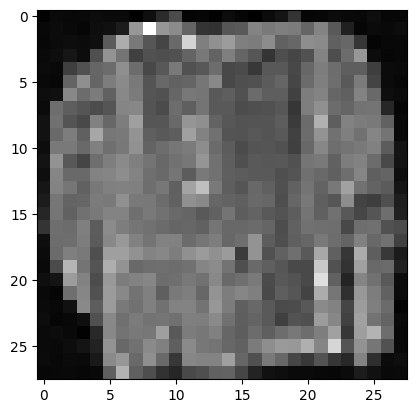

In [43]:
random_index = 1
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

以下の関数で逆拡散の過程の表示、生成した画像の最終状態を一覧で表示する。

In [ ]:
# batch_indexのバッチの画像の逆拡散過程を表示
def show_generated_img_history(samples, batch_index = 1, step = 10):
    if batch_index > len(samples[0]):
        print(f"The batch index is limited to a maximum of {len(samples[0])}.")
        return
    
    history = len(samples)
    num_of_fig = math.ceil(history / float(step)) + 1
    
    width = 5
    height = math.ceil(num_of_fig / float(width))
    fig = plt.figure(figsize=(width*1.5, height*1.6))
    plt.subplots_adjust(top=1.6, right=1.5)

    ax = fig.add_subplot(height, width, 1)
    ax.set_title(f"t: 1")
    plt.imshow(samples[0][batch_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

    for i in range(step - 1, history, step):
        ax = fig.add_subplot(height, width, int((i / step) + 2))
        ax.set_title(f"t: {i + 1}")
        plt.imshow(samples[i][batch_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")
    
    if history  % step != 0:
        ax = fig.add_subplot(height, width, num_of_fig)
        ax.set_title(f"t: {history}")
        plt.imshow(samples[-1][batch_index].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

# start ~ endまでのバッチの最終生成画像を表示
def show_generated_imgs(samples, start = 0, end = 10):
    if end <= start:
        end = start + 9

    if end > len(samples[0]):
        print(f"The batch index is limited to a maximum of {len(samples[0])}.")
        return

    num_of_fig = end - start
    
    width = 5
    height = math.ceil(num_of_fig / float(width))
    fig = plt.figure(figsize=(width*1.5, height*1.6))
    plt.subplots_adjust(top=1.6, right=1.5)
    
    for i in range(start, end):
        ax = fig.add_subplot(height, width, i + 1 - start)
        ax.set_title(f"batch {i + 1}")
        plt.imshow(samples[-1][i].reshape(image_size, image_size, channels).squeeze(), cmap="gray")

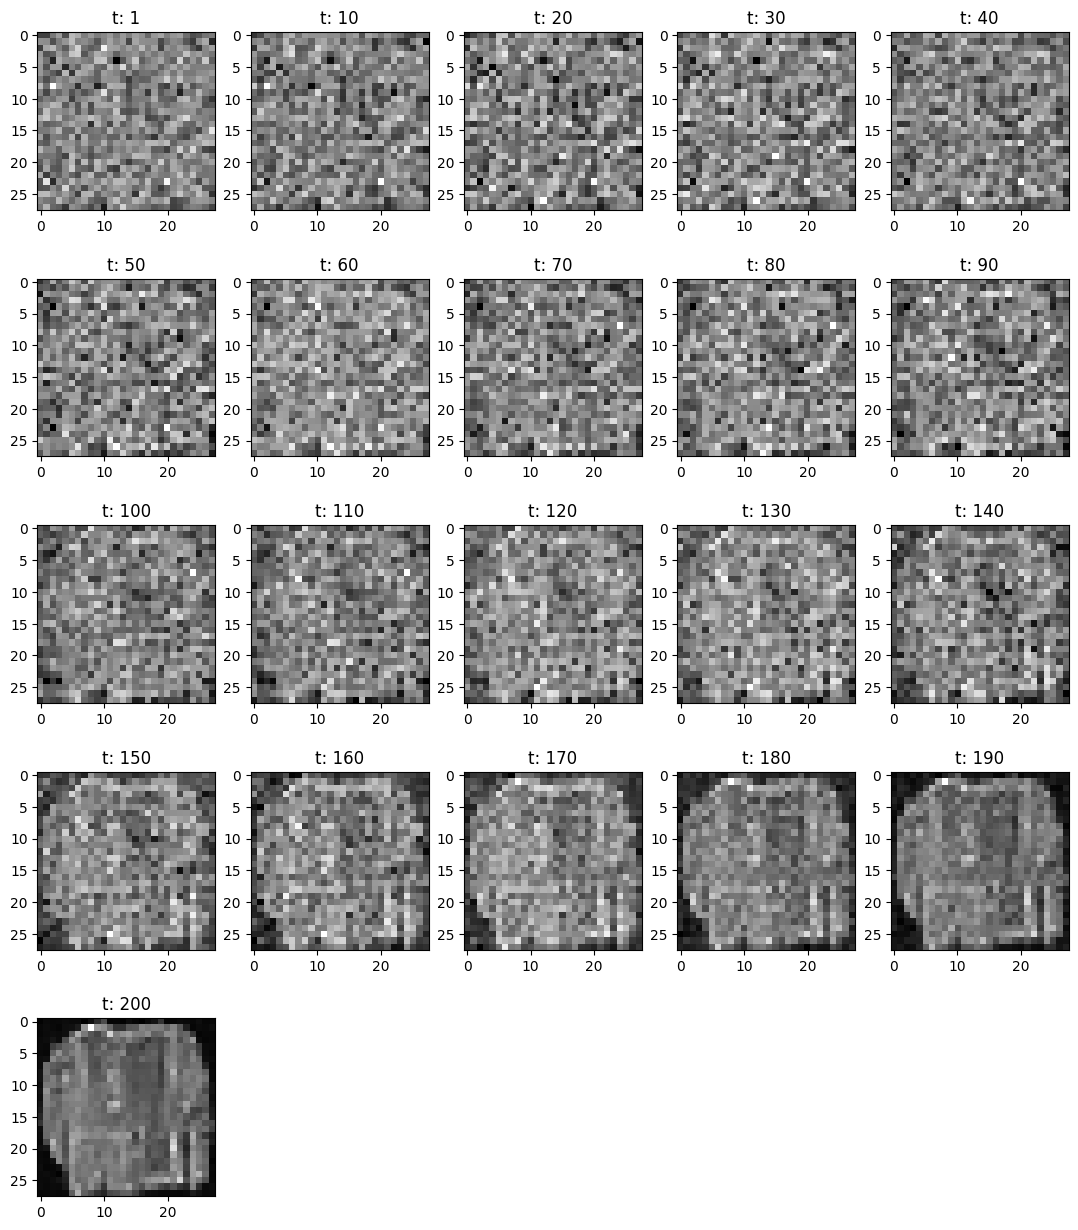

In [45]:
show_generated_img_history(samples)

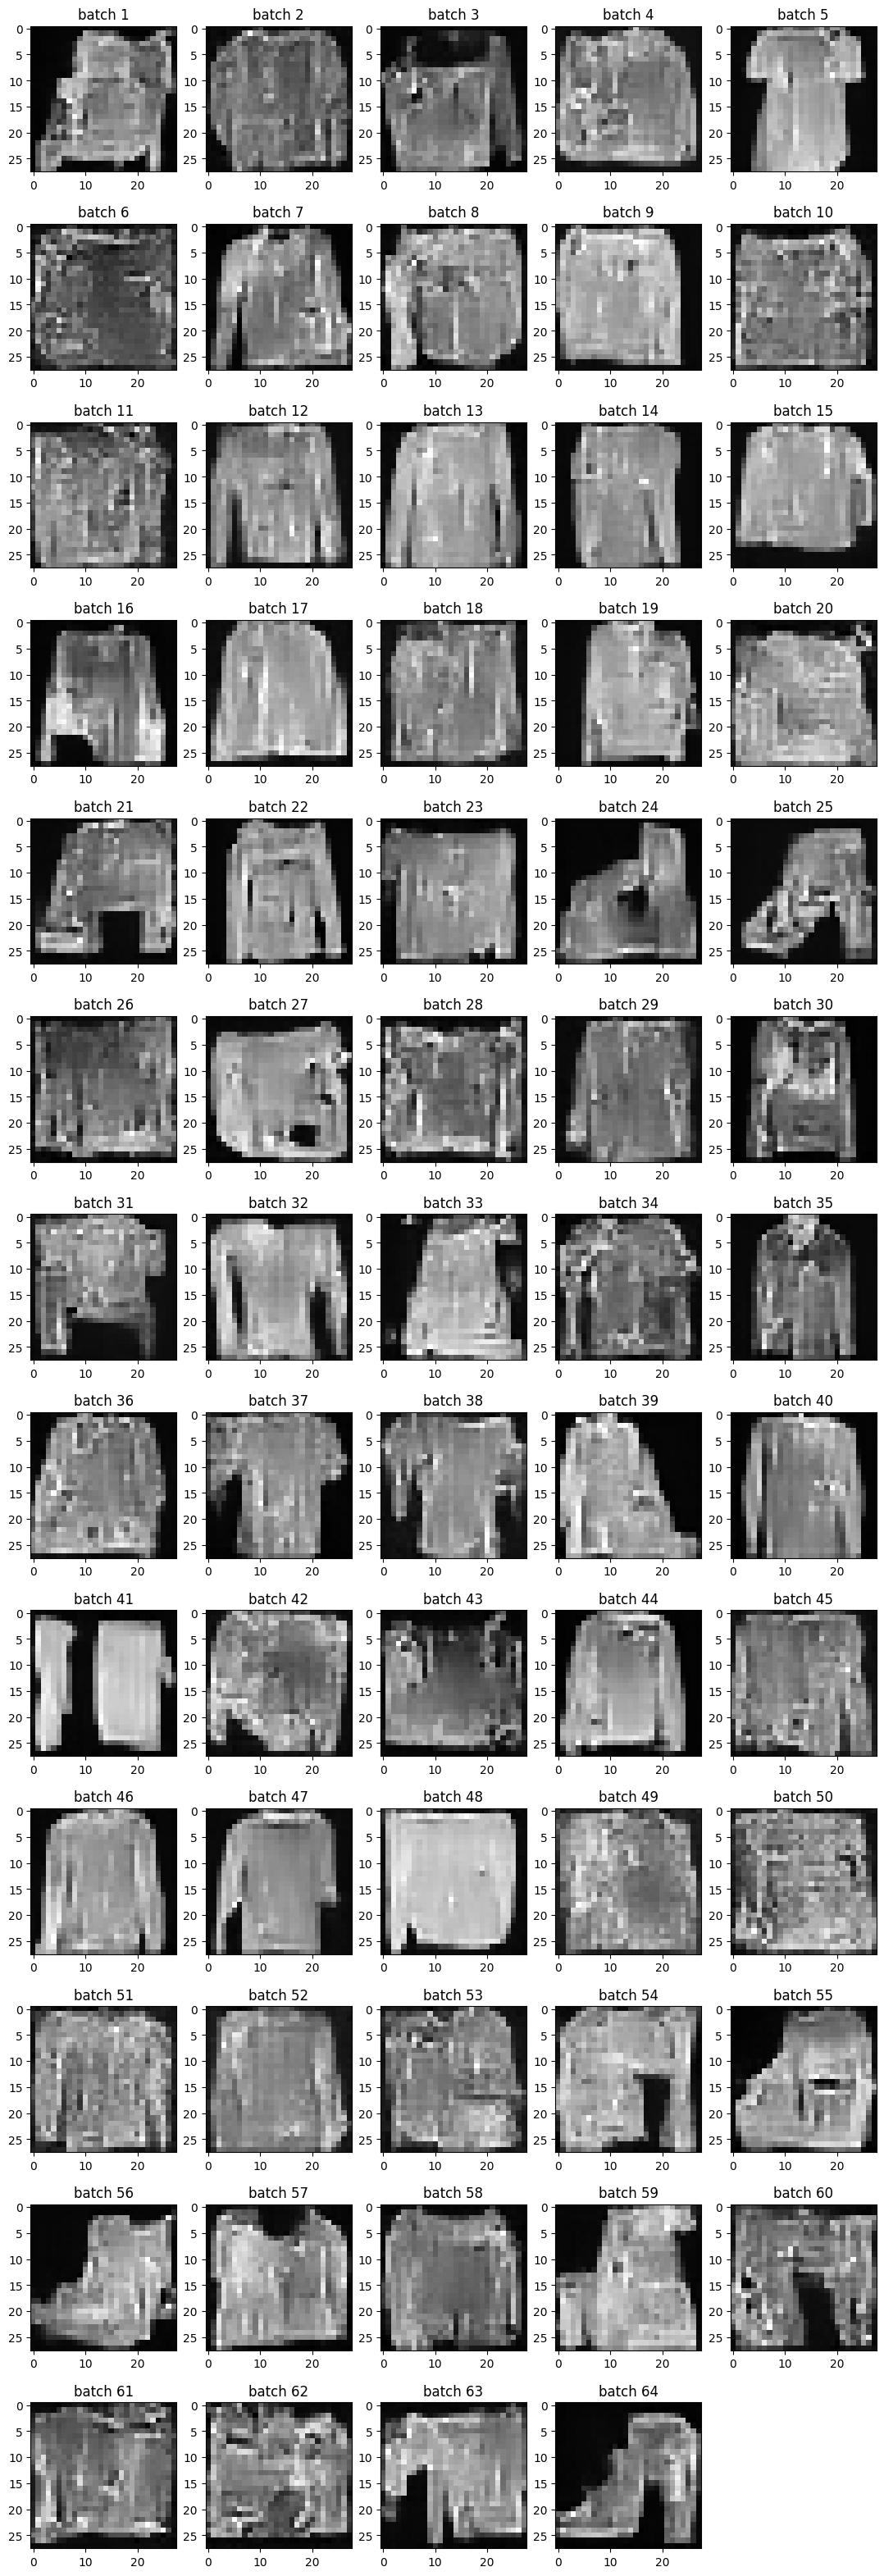

In [46]:
show_generated_imgs(samples, 0, 64)

学習後のmodelを表示する

In [47]:
print(model)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=28, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=28, out_features=28, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=28, out_features=28, bias=True)
        )
        (block1): ConvBlock(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): ConvBlock(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride=(1, 1))
      )
      (